**OpenCV Object Tracking Project**

Author: Tihoc Andrei



## First Part -- Video Generation (Technical Details)

The video is synthetically generated using Python to simulate a controlled environment for object tracking. A ball moves within a bounded 2D space, bouncing off the edges of the frame. This setup is useful for validating tracking algorithms under predictable conditions.

### Parameters:
- **Resolution**: 640×480 pixels
- **Frame Rate**: 30 FPS
- **Duration**: Configurable (e.g., 5 to 60 seconds)
- **Object**: Solid color ball with fixed radius and constant velocity vector

### Libraries Used:
- `pygame` for rendering animation frames and simulating motion
- `numpy` for array manipulation (used with Pygame surfaces)
- `moviepy.editor.ImageSequenceClip` or `cv2.VideoWriter` to encode frames into `.mp4` or `.avi` format

### Frame Generation Process:
1. Initialize screen buffer with white background
2. Update object position based on velocity
3. Check for collision with screen boundaries and invert direction if needed
4. Render frame with updated object position
5. Store the frame in memory (NumPy format)
6. After all frames are generated, encode them into a video file

In [2]:
import pygame
import moviepy.editor as mpy
import numpy as np
from pygame import Surface
# Parameters
WIDTH, HEIGHT = 640, 480
BALL_RADIUS = 20
FPS = 30
DURATION = 20  # seconds

# Ball initial position and velocity
x, y = WIDTH // 2, HEIGHT // 2
vx, vy = 5, 3

# Setup Pygame
pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))

# Collect frames
frames = []

for frame_count in range(FPS * DURATION):
    screen.fill((255, 255, 255))  # White background

    # Move ball
    x += vx
    y += vy

    # Bounce off walls
    if x - BALL_RADIUS <= 0 or x + BALL_RADIUS >= WIDTH:
        vx = -vx
    if y - BALL_RADIUS <= 0 or y + BALL_RADIUS >= HEIGHT:
        vy = -vy

    # Draw ball
    pygame.draw.circle(screen, (0, 0, 255), (x, y), BALL_RADIUS)

    # Convert Pygame surface to numpy array for moviepy
    frame = pygame.surfarray.array3d(screen)
    frame = np.transpose(frame, (1, 0, 2))  # Convert from (width, height) to (height, width)
    frames.append(frame)

pygame.quit()

# Create video
clip = mpy.ImageSequenceClip(frames, fps=FPS)
clip.write_videofile("bouncing_ball.mp4", codec="libx264")


Moviepy - Building video bouncing_ball.mp4.
Moviepy - Writing video bouncing_ball.mp4



Moviepy - Done !
Moviepy - video ready bouncing_ball.mp4


## Second Part -- Object Tracking with GOTURN

This section applies OpenCV's GOTURN tracker to the synthetic video to detect and follow the blue bouncing ball across frames.

### Steps:
1. Load the synthetic video.
2. Manually define the bounding box around the ball in the first frame.
3. Initialize the GOTURN tracker with that bounding box.
4. Process each frame and update the tracker.
5. Draw the tracking bounding box and write the tracked video.

### Output:
- The tracked video is saved as `bouncing_ball-GOTURN.mp4`.

### Requirements:
- `opencv-contrib-python`
- `moviepy`
- `numpy`

Ensure GOTURN model is supported in your OpenCV installation. If not, use an alternate tracker like `KCF` or `CSRT`.

## Notes:
- GOTURN may not perform perfectly on fast-moving objects unless the pretrained Caffe model is used.
- For best results, combine motion prediction with color thresholding or template matching if GOTURN fails.
- OpenCV must be built with `opencv_contrib` to include GOTURN and other advanced trackers.
- The model files `goturn.prototxt` and `goturn.caffemodel` may be needed in certain vers

In [10]:
import cv2
import sys
from matplotlib import pyplot as plt
from IPython.display import HTML
from base64 import b64encode

# === Helper Functions ===
def draw_rectangle(frame, bbox):
    p1 = (int(bbox[0]), int(bbox[1]))
    p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
    cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)

def draw_text(frame, text, location, color=(50, 170, 50)):
    cv2.putText(frame, text, location, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

def display_rectangle(frame, bbox):
    plt.figure(figsize=(12, 6))
    frame_copy = frame.copy()
    draw_rectangle(frame_copy, bbox)
    frame_copy = cv2.cvtColor(frame_copy, cv2.COLOR_RGB2BGR)
    plt.imshow(frame_copy)
    plt.axis("off")
    plt.show()

In [11]:
# === Load input video ===
video_input_file_name = "bouncing_ball.mp4"
video = cv2.VideoCapture(video_input_file_name)
ok, frame = video.read()

if not video.isOpened() or not ok:
    print("Could not open video or read the first frame.")
    sys.exit()


In [12]:
# === Parameters from video generation ===
WIDTH, HEIGHT = 640, 480
BALL_RADIUS = 20
FPS = 30
DURATION = 20


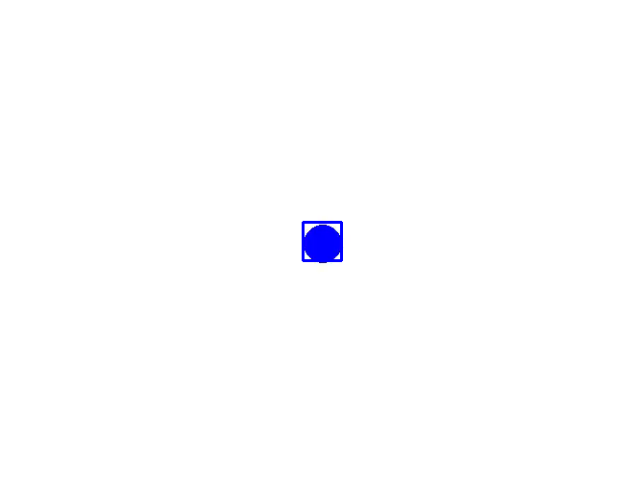

In [14]:
# === Define initial bounding box ===
# Ball starts at (320, 240), radius 20 → bbox = (300, 220, 40, 40)
bbox = (320 - BALL_RADIUS+4, 240 - BALL_RADIUS, BALL_RADIUS * 2, BALL_RADIUS * 2)
display_rectangle(frame, bbox)

In [15]:
# === Create and initialize GOTURN tracker ===
tracker = cv2.TrackerGOTURN.create()
ok = tracker.init(frame, bbox)


In [16]:
# === Setup output video writer ===
video_output_file_name = "bouncing_ball-GOTURN.mp4"
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)

video_out = cv2.VideoWriter(
    video_output_file_name,
    cv2.VideoWriter_fourcc(*"XVID"),
    fps,
    (width, height)
)


In [17]:
# === Tracking loop ===
while True:
    ok, frame = video.read()
    if not ok:
        break

    timer = cv2.getTickCount()
    ok, bbox = tracker.update(frame)
    fps_val = cv2.getTickFrequency() / (cv2.getTickCount() - timer)

    if ok:
        draw_rectangle(frame, bbox)
    else:
        draw_text(frame, "Tracking failure detected", (80, 140), (0, 0, 255))

    draw_text(frame, "GOTURN Tracker", (80, 60))
    draw_text(frame, f"FPS : {int(fps_val)}", (80, 100))
    video_out.write(frame)

video.release()
video_out.release()
print(f"Tracking complete. Output saved as: {video_output_file_name}")

Tracking complete. Output saved as: bouncing_ball-GOTURN.mp4


The output can be visualized at: https://github.com/AndreiTihoc/AI_Projects/blob/main/bouncing_ball-GOTURN.mp4
